<a href="https://colab.research.google.com/github/benbatman/CNN_Projects/blob/main/ResNet_Fruits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using transfer learning with the ResNet 50 model on the fruits 360 dataset to achieve ~97-98% accuracy 

Original code from the Lazy Programmers course on Udemy: Deep learning: Advanced Computer Vision 

In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten 
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

from sklearn.metrics import confusion_matrix 
import numpy as np 
import matplotlib.pyplot as plt 
import random

from glob import glob 
import itertools 

In [2]:
# Re-size all the images to this 
IMAGE_SIZE = [100, 100] 

# Training config
EPOCHS = 16 
BATCH_SIZE = 32

In [3]:
# Get dataset from GitHub
!git clone https://github.com/Horea94/Fruit-Images-Dataset.git

Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 385858, done.
remote: Counting objects: 100% (8693/8693), done.
remote: Compressing objects: 100% (8659/8659), done.
remote: Total 385858 (delta 37), reused 8688 (delta 34), pack-reused 377165
Receiving objects: 100% (385858/385858), 2.10 GiB | 16.44 MiB/s, done.
Resolving deltas: 100% (1197/1197), done.
Updating files: 100% (90503/90503), done.


In [4]:
#!unzip -nq fruits-360.zip

In [5]:
train_path = 'Fruit-Images-Dataset/Training'
valid_path = 'Fruit-Images-Dataset/Test'

In [6]:
# Useful for getting number of files 
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [7]:
image_files[:10], valid_image_files[:10]

(['Fruit-Images-Dataset/Training/Walnut/r_239_100.jpg',
  'Fruit-Images-Dataset/Training/Walnut/r2_73_100.jpg',
  'Fruit-Images-Dataset/Training/Walnut/r2_266_100.jpg',
  'Fruit-Images-Dataset/Training/Walnut/r2_42_100.jpg',
  'Fruit-Images-Dataset/Training/Walnut/46_100.jpg',
  'Fruit-Images-Dataset/Training/Walnut/r2_8_100.jpg',
  'Fruit-Images-Dataset/Training/Walnut/291_100.jpg',
  'Fruit-Images-Dataset/Training/Walnut/101_100.jpg',
  'Fruit-Images-Dataset/Training/Walnut/r2_31_100.jpg',
  'Fruit-Images-Dataset/Training/Walnut/204_100.jpg'],
 ['Fruit-Images-Dataset/Test/Walnut/r_209_100.jpg',
  'Fruit-Images-Dataset/Test/Walnut/318_100.jpg',
  'Fruit-Images-Dataset/Test/Walnut/317_100.jpg',
  'Fruit-Images-Dataset/Test/Walnut/177_100.jpg',
  'Fruit-Images-Dataset/Test/Walnut/r2_219_100.jpg',
  'Fruit-Images-Dataset/Test/Walnut/r_304_100.jpg',
  'Fruit-Images-Dataset/Test/Walnut/r2_242_100.jpg',
  'Fruit-Images-Dataset/Test/Walnut/r2_222_100.jpg',
  'Fruit-Images-Dataset/Test/Walnut

In [8]:
# Useful for getting number of classes 
folders = glob(train_path + '/*')
folders[:10], len(folders)

(['Fruit-Images-Dataset/Training/Walnut',
  'Fruit-Images-Dataset/Training/Huckleberry',
  'Fruit-Images-Dataset/Training/Grapefruit White',
  'Fruit-Images-Dataset/Training/Plum',
  'Fruit-Images-Dataset/Training/Strawberry',
  'Fruit-Images-Dataset/Training/Apple Golden 1',
  'Fruit-Images-Dataset/Training/Quince',
  'Fruit-Images-Dataset/Training/Apple Red Yellow 2',
  'Fruit-Images-Dataset/Training/Pear',
  'Fruit-Images-Dataset/Training/Cherry Wax Black'],
 131)

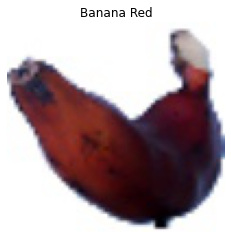

In [9]:
# Look at an iamge for fun 
rand_image = np.random.choice(image_files)
plt.imshow(image.load_img(rand_image))
plt.title(rand_image.split("/")[2])
plt.axis(False);

In [ ]:
# Plot multiple random images
fig = plt.figure(figsize=(10,7))
r, c = 5,5
for i in range(1, r*c+1):
  rand_idx = random.randint(0, len())
  image, label = [rand_idx]
  fig.add_subplot(r,c,i)
  plt.imshow(image.permute(1,2,0).squeeze())
  plt.title([label])
  plt.axis(False)

In [10]:
# Get the resnet base model 
# Add [3] to IMAGE_SIZE for color channel
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


94765736/94765736 [==============================] - 5s 0us/step


In [11]:
# Don't want to train the existing layers/weights
for layer in res.layers:
  layer.trainable = False

In [12]:
# Custom layers 
x = Flatten()(res.output)
# can add more layers
prediction = Dense(len(folders), activation='softmax')(x)

In [13]:
# Create the model 
model = Model(inputs=res.input, outputs=prediction)

In [14]:
# View summary of model 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']         

In [15]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
# Create an ImageDataGenerator 
train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2, 
    horizontal_flip=True, 
    vertical_flip=True, 
    preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator( 
    preprocessing_function=preprocess_input
)

In [17]:
# Get label mapping for confusion matrix plot later 
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 22688 images belonging to 131 classes.
{'Apple Braeburn': 0, 'Apple Crimson Snow': 1, 'Apple Golden 1': 2, 'Apple Golden 2': 3, 'Apple Golden 3': 4, 'Apple Granny Smith': 5, 'Apple Pink Lady': 6, 'Apple Red 1': 7, 'Apple Red 2': 8, 'Apple Red 3': 9, 'Apple Red Delicious': 10, 'Apple Red Yellow 1': 11, 'Apple Red Yellow 2': 12, 'Apricot': 13, 'Avocado': 14, 'Avocado ripe': 15, 'Banana': 16, 'Banana Lady Finger': 17, 'Banana Red': 18, 'Beetroot': 19, 'Blueberry': 20, 'Cactus fruit': 21, 'Cantaloupe 1': 22, 'Cantaloupe 2': 23, 'Carambula': 24, 'Cauliflower': 25, 'Cherry 1': 26, 'Cherry 2': 27, 'Cherry Rainier': 28, 'Cherry Wax Black': 29, 'Cherry Wax Red': 30, 'Cherry Wax Yellow': 31, 'Chestnut': 32, 'Clementine': 33, 'Cocos': 34, 'Corn': 35, 'Corn Husk': 36, 'Cucumber Ripe': 37, 'Cucumber Ripe 2': 38, 'Dates': 39, 'Eggplant': 40, 'Fig': 41, 'Ginger Root': 42, 'Granadilla': 43, 'Grape Blue': 44, 'Grape Pink': 45, 'Grape White': 46, 'Grape White 2': 47, 'Grape White 3': 48, 'Grape Wh

min: -72.68 max: 151.061


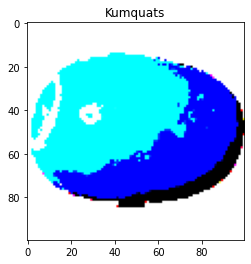

In [18]:
# Will be strangely colored 
for x, y in test_gen: 
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [19]:
# Create generators 
train_generator = train_gen.flow_from_directory(
    train_path, 
    target_size=IMAGE_SIZE, 
    shuffle=True, 
    batch_size=BATCH_SIZE, 
    class_mode='sparse'
)
valid_generator = val_gen.flow_from_directory(
    valid_path, 
    target_size=IMAGE_SIZE, 
    shuffle=False, 
    batch_size=BATCH_SIZE, 
    class_mode='sparse'
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [27]:
# If wanted to add callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os 
from pathlib import Path

early_stopping = EarlyStopping(monitor='val_los', patience=8, min_delta=0.005,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_delta=0.01)

if not os.path.exists(Path("checkpoints/")):
  os.mkdir("checkpoints/")

checkpoint_dir = "checkpoints/model_0_checkpoint"

checkpoint_callback = ModelCheckpoint(checkpoint_dir, monitor='val_loss', 
                                      save_best_only = True)

In [20]:
# Fit the model 
history_0 = model.fit(
    train_generator,
    validation_data=valid_generator, 
    epochs=EPOCHS,
    steps_per_epoch=len(image_files)//BATCH_SIZE, 
    validation_steps=len(valid_image_files)//BATCH_SIZE
)

Epoch 1/16
2115/2115 [==============================] - 311s 142ms/step - loss: 1.4828 - accuracy: 0.9055 - val_loss: 1.7910 - val_accuracy: 0.9435
Epoch 2/16
2115/2115 [==============================] - 289s 137ms/step - loss: 0.6851 - accuracy: 0.9677 - val_loss: 2.9843 - val_accuracy: 0.9335
Epoch 3/16
2115/2115 [==============================] - 314s 148ms/step - loss: 0.5929 - accuracy: 0.9782 - val_loss: 2.5558 - val_accuracy: 0.9482
Epoch 4/16
2115/2115 [==============================] - 269s 127ms/step - loss: 0.5244 - accuracy: 0.9827 - val_loss: 1.8144 - val_accuracy: 0.9638
Epoch 5/16
2115/2115 [==============================] - 244s 115ms/step - loss: 0.4461 - accuracy: 0.9863 - val_loss: 1.4550 - val_accuracy: 0.9704
Epoch 6/16
2115/2115 [==============================] - 288s 136ms/step - loss: 0.3555 - accuracy: 0.9894 - val_loss: 1.7976 - val_accuracy: 0.9703
Epoch 7/16
2115/2115 [==============================] - 305s 144ms/step - loss: 0.3659 - accuracy: 0.9901 - val_

In [31]:
loss, acc = model.evaluate(valid_generator)

709/709 [==============================] - 26s 36ms/step - loss: 2.2081 - accuracy: 0.9724


In [28]:
# Save the weights 
model.save_weights(checkpoint_dir)

In [33]:
# Load weights back in and evaluate the model 
model.load_weights("/content/checkpoints/model_0_checkpoint")

loaded_loss, loaded_acc = model.evaluate(valid_generator)
print(f"Loaded model loss: {loaded_loss} | acc: {loaded_acc}")

709/709 [==============================] - 27s 38ms/step - loss: 2.2081 - accuracy: 0.9724
Loaded model loss: 2.2080533504486084 | acc: 0.9723642468452454


In [34]:
np.isclose(acc, loaded_acc)

True

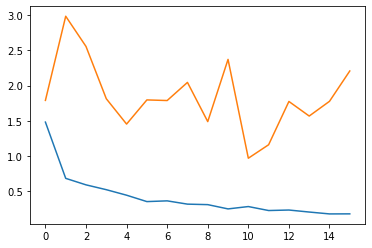

In [35]:
# Plot the loss 
plt.plot(history_0.history['loss'], label='train_loss')
plt.plot(history_0.history['val_loss'], label='val_loss')

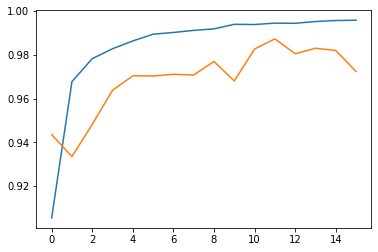

In [37]:
plt.plot(history_0.history['accuracy'], label='train_acc')
plt.plot(history_0.history['val_accuracy'], label='val_acc')

In [40]:
def get_confusion_matrix(data_path, N):

  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i=0
  n_images = 0 
  for x, y in val_gen.flow_from_directory(
      data_path, 
      target_size=IMAGE_SIZE, 
      shuffle=False, 
      batch_size=BATCH_SIZE*2
      ):
    i += 1
    n_images += len(y)
    if i % 50 == 0:
      print(f"{n_images} images processed")
    p = model.predict(x)
    p = np.argmax(y, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets,y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm 

In [41]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 67692
Found 67692 images belonging to 131 classes.
2/2 [==============================] - 0s 26ms/step
3200 images processed
2/2 [==============================] - 0s 30ms/step
6400 images processed
2/2 [==============================] - 0s 28ms/step
9600 images processed
2/2 [==============================] - 0s 22ms/step
12800 images processed
2/2 [==============================] - 0s 30ms/step
16000 images processed
2/2 [==============================] - 0s 25ms/step
19200 images processed
2/2 [==============================] - 0s 33ms/step
22400 images processed
2/2 [==============================] - 0s 28ms/step
25600 images processed
2/2 [==============================] - 0s 29ms/step
28800 images processed
2/2 [==============================] - 0s 27ms/step
32000 images processed
2/2 [==============================] - 0s 34ms/step
35200 images processed
2/2 [==============================] - 0s 32ms/step
38400 images processed
2/2 [===================

In [42]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 22688
Found 22688 images belonging to 131 classes.
2/2 [==============================] - 0s 27ms/step
3200 images processed
2/2 [==============================] - 0s 22ms/step
6400 images processed
2/2 [==============================] - 0s 25ms/step
9600 images processed
2/2 [==============================] - 0s 27ms/step
12800 images processed
2/2 [==============================] - 0s 25ms/step
16000 images processed
2/2 [==============================] - 0s 35ms/step
19200 images processed
2/2 [==============================] - 0s 24ms/step
22400 images processed
1/1 [==============================] - 0s 26ms/step
[[164   0   0 ...   0   0   0]
 [  0 148   0 ...   0   0   0]
 [  0   0 160 ...   0   0   0]
 ...
 [  0   0   0 ... 158   0   0]
 [  0   0   0 ...   0 249   0]
 [  0   0   0 ...   0   0 157]]


In [46]:
def plot_confusion_matrix(cm, classes, 
                          normalize=False, 
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")

  print(cm)

  plt.figure(figsize=(25, 25))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i,j], fmt),
             horizontalalignment='center',
             color='white' if cm[i,j] > threshold else 'black')
    
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[492   0   0 ...   0   0   0]
 [  0 444   0 ...   0   0   0]
 [  0   0 480 ...   0   0   0]
 ...
 [  0   0   0 ... 474   0   0]
 [  0   0   0 ...   0 735   0]
 [  0   0   0 ...   0   0 475]]


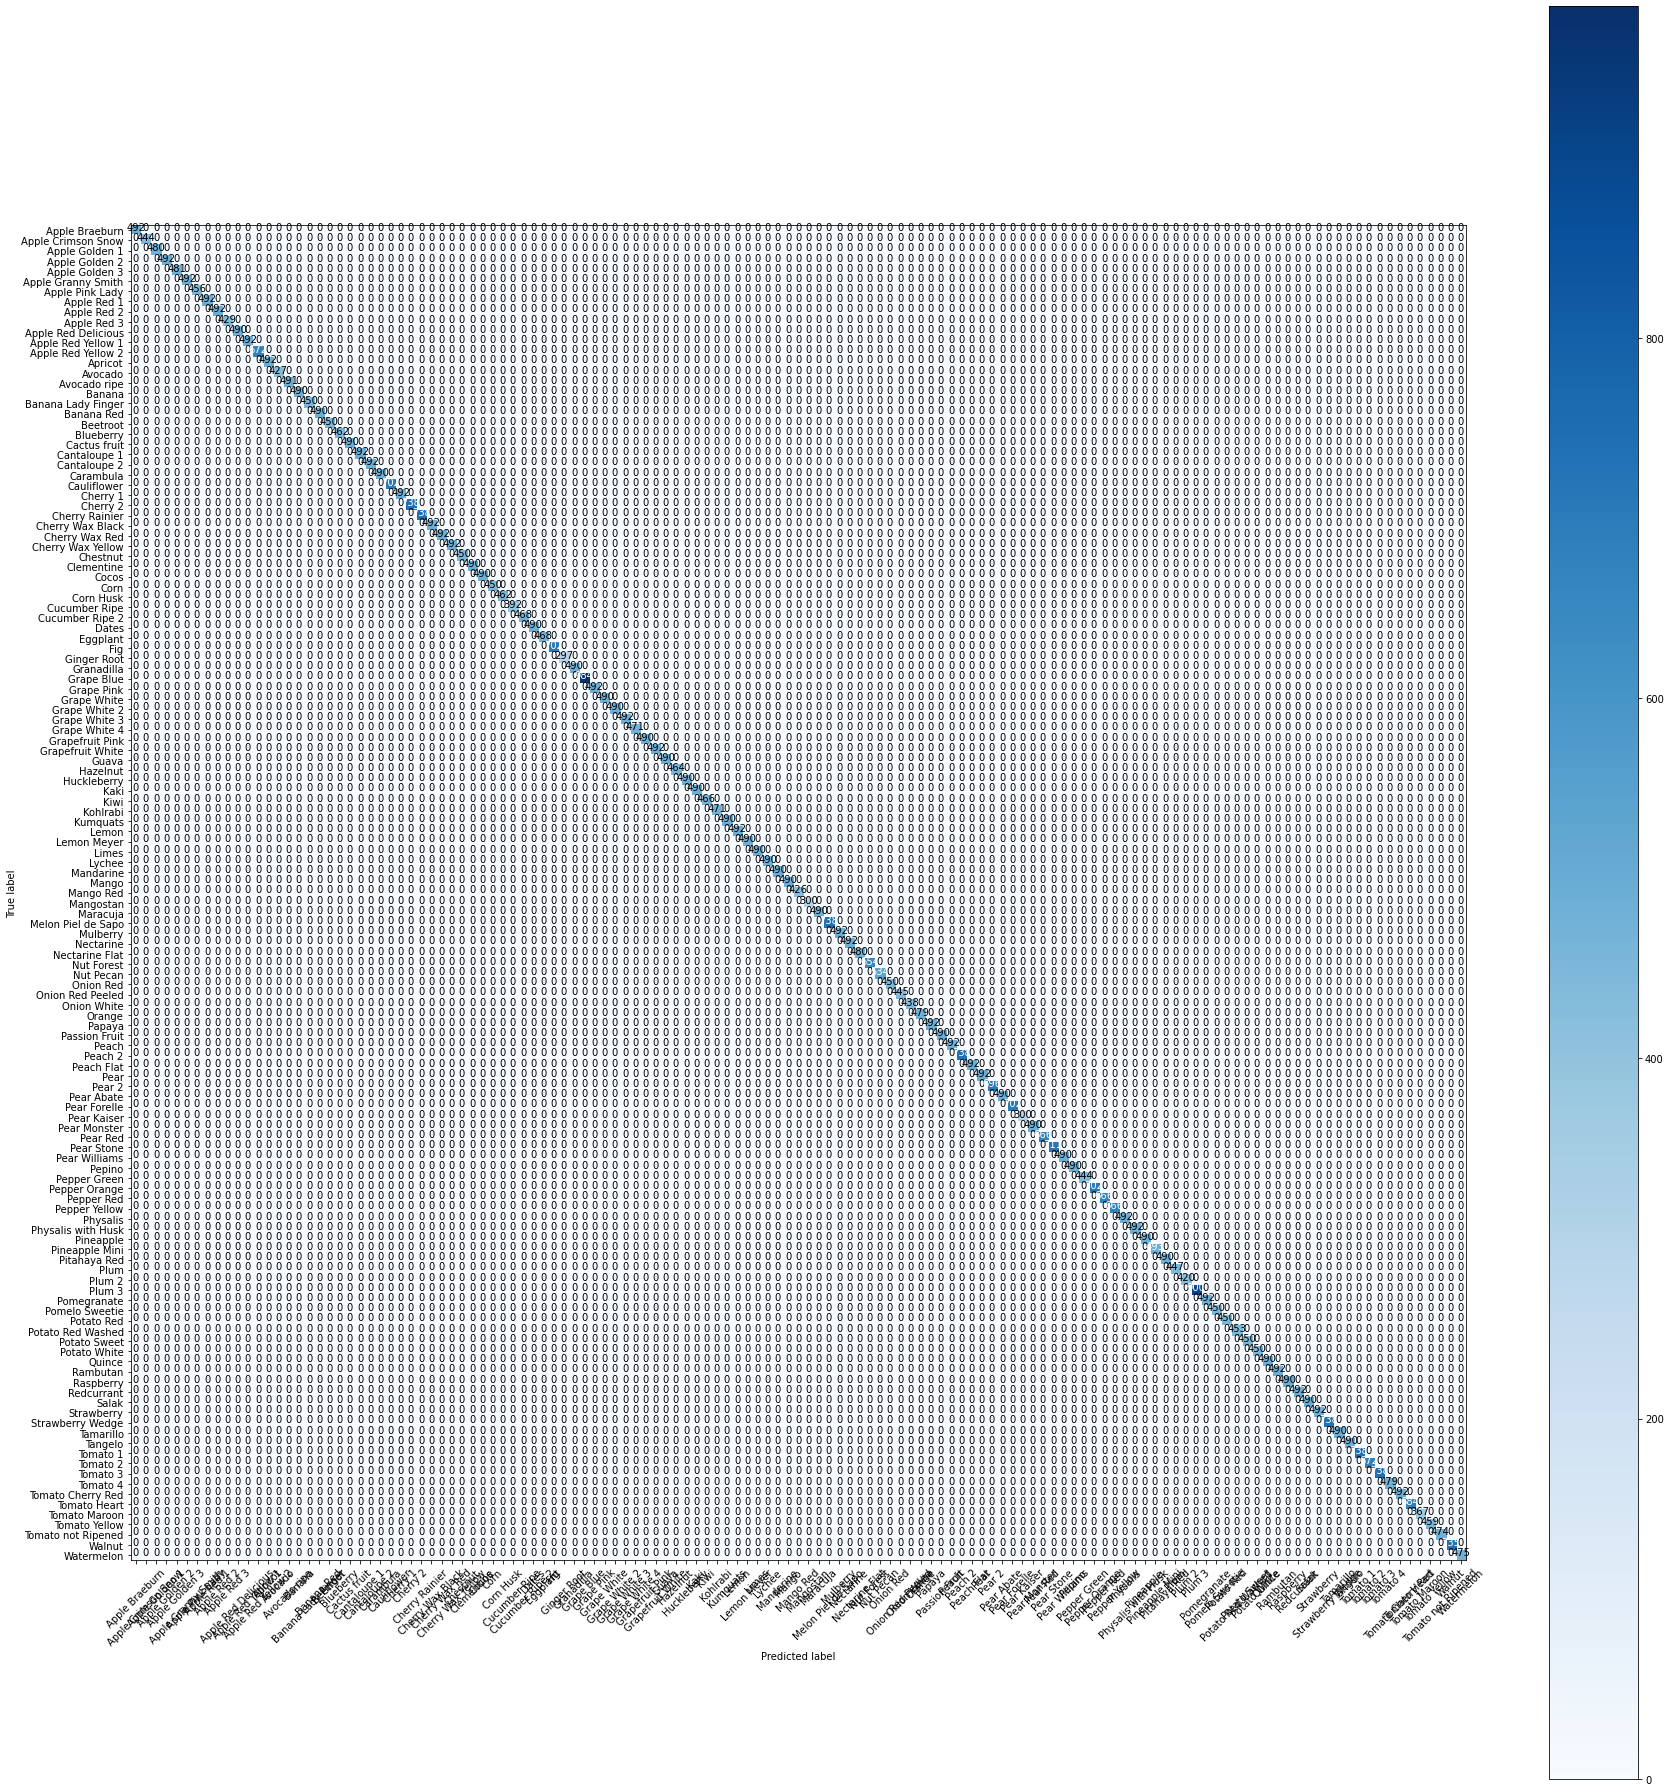

In [47]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')

Confusion matrix, without normalization
[[164   0   0 ...   0   0   0]
 [  0 148   0 ...   0   0   0]
 [  0   0 160 ...   0   0   0]
 ...
 [  0   0   0 ... 158   0   0]
 [  0   0   0 ...   0 249   0]
 [  0   0   0 ...   0   0 157]]


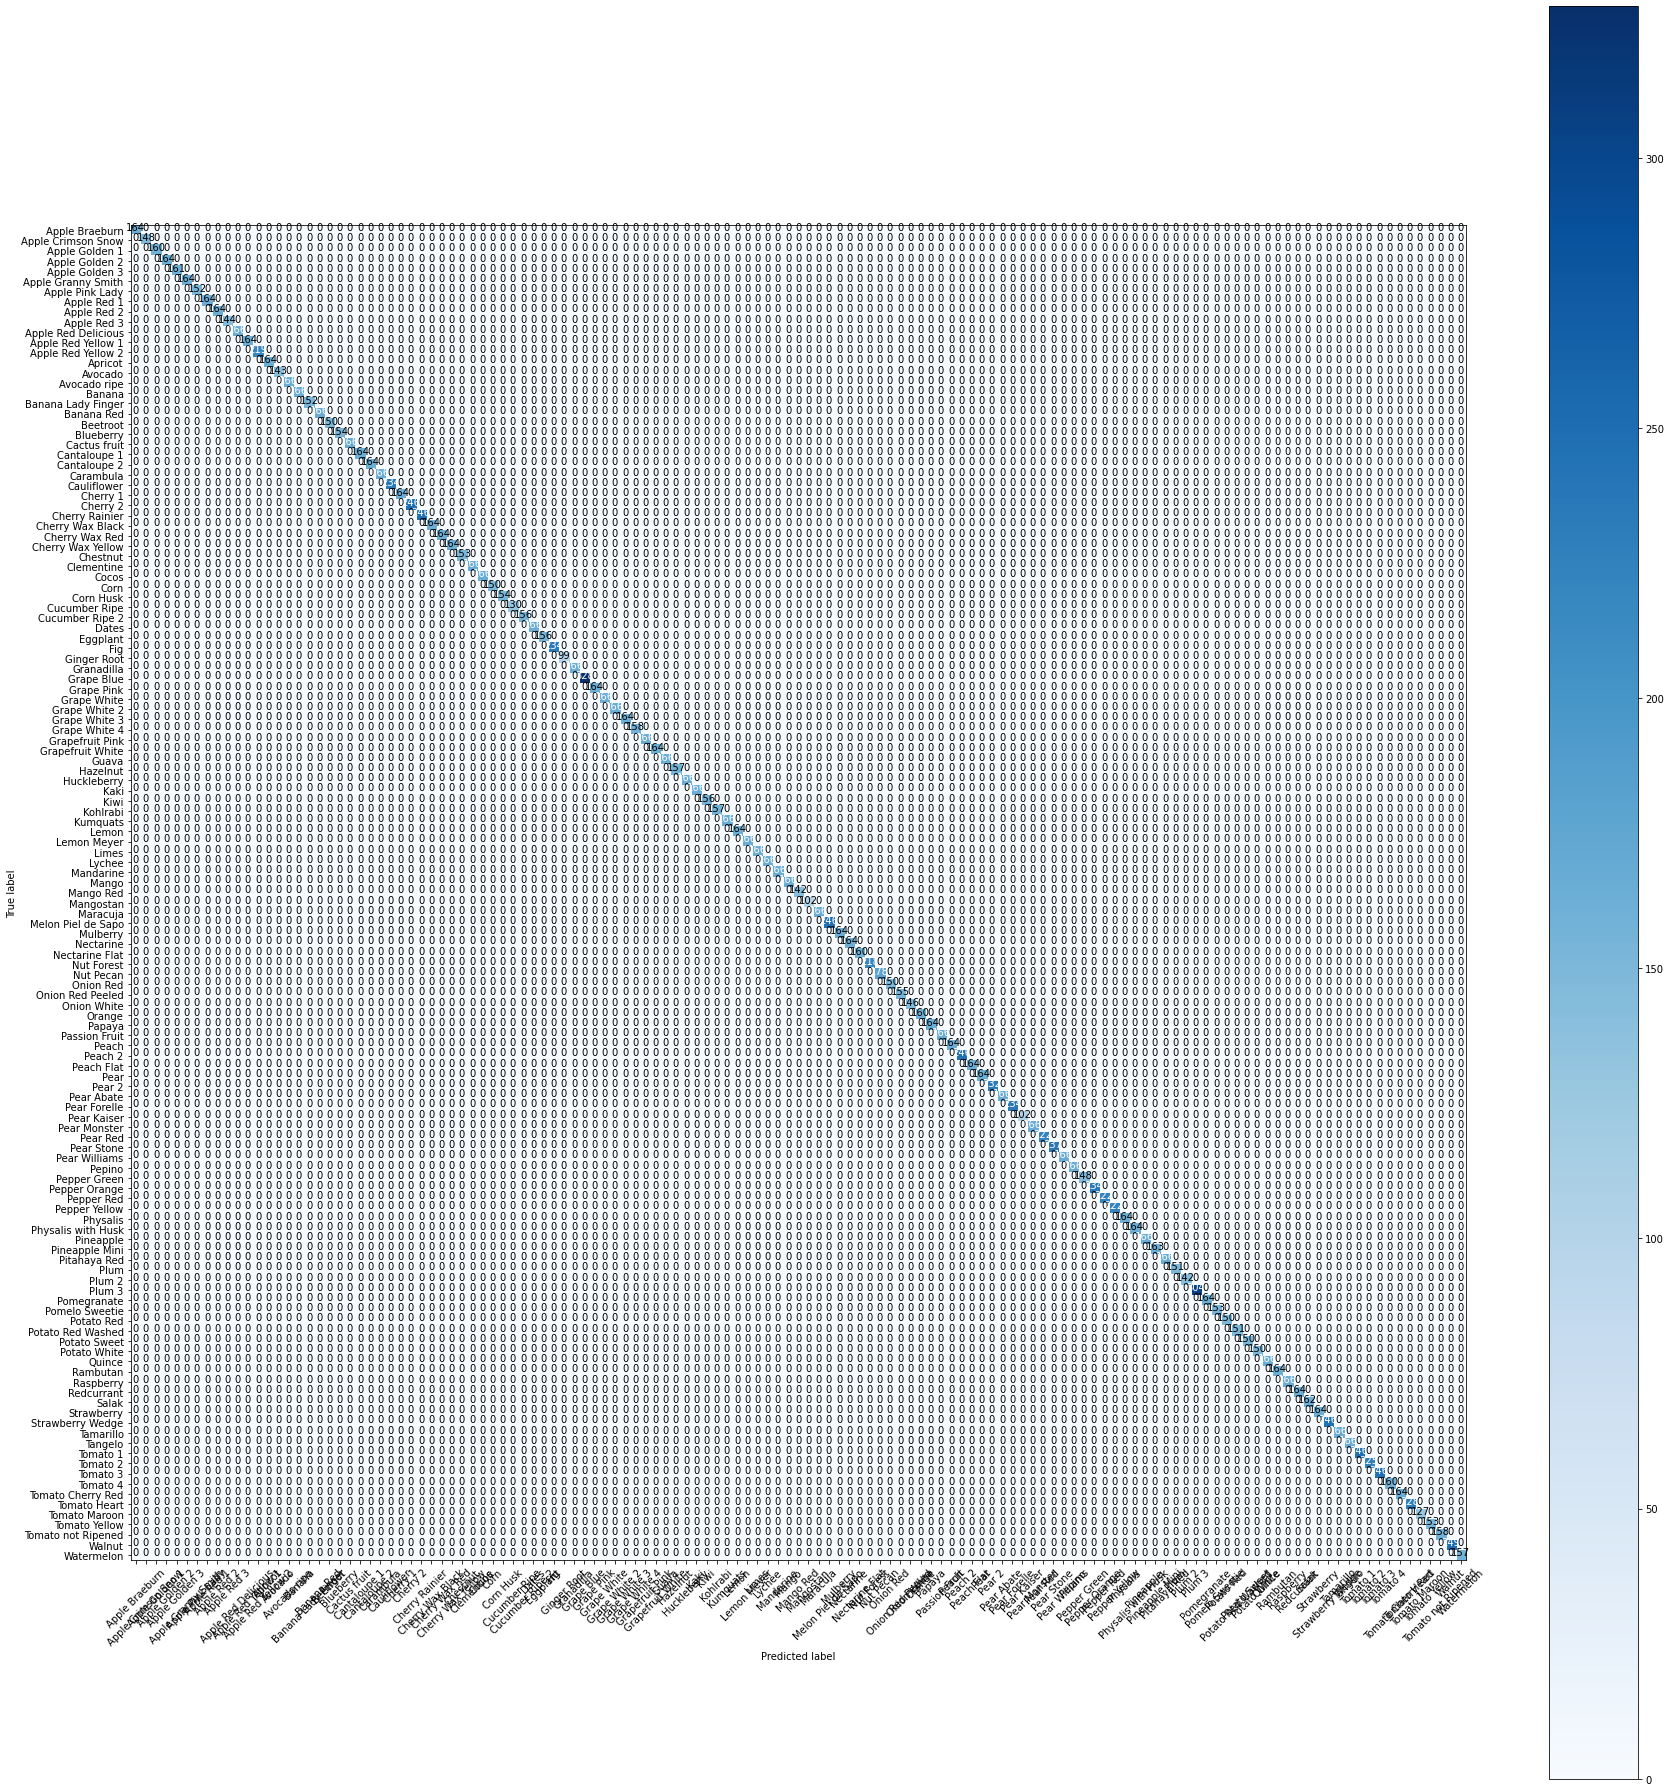

In [48]:
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')